# Ejercicio 1 - Indexado BSBI y corpus de Wikipedia

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import pickle

from ejercicio1.IRSystemBSBI import IRSystemBSBI
from ejercicio1.IndexadorBSBI import IndexadorBSBI
from lib.Tokenizador import Tokenizador
from lib.Posting import Posting

CORPUS_PATH = "datos/en"
INDEX_DIR = "index"


# Analiza la colección: cuenta documentos y suma tamaño total (solo .txt y .html)
def analizar_corpus(corpus_path):
    total_docs = 0
    total_size = 0
    for root, _, files in os.walk(corpus_path):
        for fname in files:
            if fname.endswith((".txt", ".html")):
                total_docs += 1
                total_size += os.path.getsize(os.path.join(root, fname))
    return total_docs, total_size


total_docs, size_corpus = analizar_corpus(CORPUS_PATH)
print(f"Total de documentos en la colección: {total_docs}")
print(f"Tamaño total de la colección: {size_corpus/1024/1024:.2f} MB")

Total de documentos en la colección: 6043


## Prueba con varios valores de n (10%, 20%, 50% del total)

In [2]:
n_values = [max(1, int(total_docs * frac)) for frac in [0.1, 0.2, 0.5]]
resultados = []

for n in n_values:
    print(f"\nIndexando con n = {n} (volcado cada {n} documentos)...")
    tokenizer = Tokenizador()
    indexador = IndexadorBSBI(tokenizer, memory_limit=n, path_index=f"{INDEX_DIR}_n{n}")

    # Indexación
    t0 = time.time()
    indexador.index_collection(CORPUS_PATH)
    t1 = time.time()

    # Medir tamaño del índice en disco
    postings_path = os.path.join(f"{INDEX_DIR}_n{n}", "final_index.bin")
    vocab_path = os.path.join(f"{INDEX_DIR}_n{n}", "vocabulary.pkl")
    size_postings = (
        os.path.getsize(postings_path) if os.path.exists(postings_path) else 0
    )
    size_vocab = os.path.getsize(vocab_path) if os.path.exists(vocab_path) else 0

    # Cargar vocabulario para graficar distribución de posting lists
    with open(vocab_path, "rb") as f:
        vocabulario = pickle.load(f)
    posting_sizes = [v["df"] for v in vocabulario.values()]

    resultados.append(
        {
            "n": n,
            "tiempo_total": t1 - t0,
            "size_postings": size_postings,
            "size_vocab": size_vocab,
            "posting_sizes": posting_sizes,
        }
    )


Indexando con n = 604 (volcado cada 604 documentos)...
Procesando documento 6043: BBC_Global_30_dc4a.htmln_Program_57c5.htmlfb.html)_6312.htmlAnti-Fraud_da21.htmlhtmlef3b.htmltml
Indexando con n = 1208 (volcado cada 1208 documentos)...
Procesando documento 6043: BBC_Global_30_dc4a.htmln_Program_57c5.htmlfb.html)_6312.htmlAnti-Fraud_da21.htmlhtmlef3b.htmltml
Indexando con n = 3021 (volcado cada 3021 documentos)...
Procesando documento 6043: BBC_Global_30_dc4a.htmln_Program_57c5.htmlfb.html)_6312.htmlAnti-Fraud_da21.htmlhtmlef3b.htmltml

In [3]:
print("Resultados:")
for i, r in enumerate(resultados):
    print(f"n={r['n']}:")
    print(f"  Tiempo total: {r['tiempo_total']:.2f} segundos")
    print(f"  Tamaño del índice en disco: {r['size_postings'] + r['size_vocab']} bytes")
    print(f"  Tamaño de postings: {r['size_postings']} bytes")
    print(f"  Tamaño de vocabulario: {r['size_vocab']} bytes")
    print(f"  Cantidad de posting lists: {len(r['posting_sizes'])}")
    print(f"  Tamaño máximo de posting list: {max(r['posting_sizes'])}")

Resultados:
n=604:
  Tiempo total: 63.33 segundos
  Tamaño del índice en disco: 20797099 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061379 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043
n=1208:
  Tiempo total: 66.13 segundos
  Tamaño del índice en disco: 20797099 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061379 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043
n=3021:
  Tiempo total: 70.76 segundos
  Tamaño del índice en disco: 20797099 bytes
  Tamaño de postings: 15735720 bytes
  Tamaño de vocabulario: 5061379 bytes
  Cantidad de posting lists: 198216
  Tamaño máximo de posting list: 6043


## Gráfica: Tiempos de indexación para cada valor de N

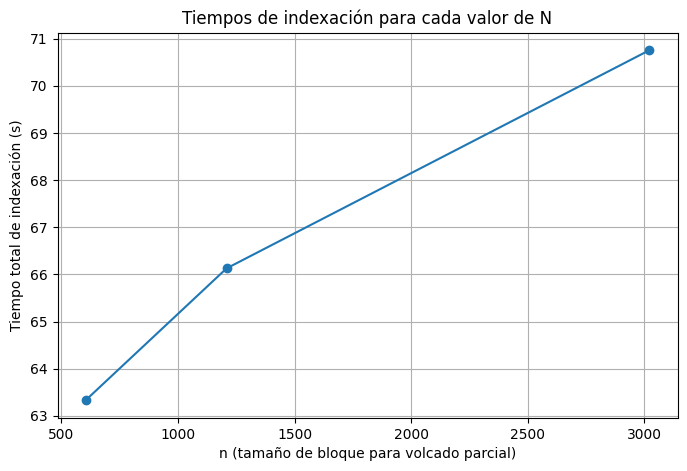

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(
    [r["n"] for r in resultados], [r["tiempo_total"] for r in resultados], marker="o"
)
plt.xlabel("n (tamaño de bloque para volcado parcial)")
plt.ylabel("Tiempo total de indexación (s)")
plt.title("Tiempos de indexación para cada valor de N")
plt.grid(True)
plt.show()

## Gráfica: Distribución de tamaños de posting lists
La distribución es la misma para los tres tamaños de N (solo se muestra un caso).

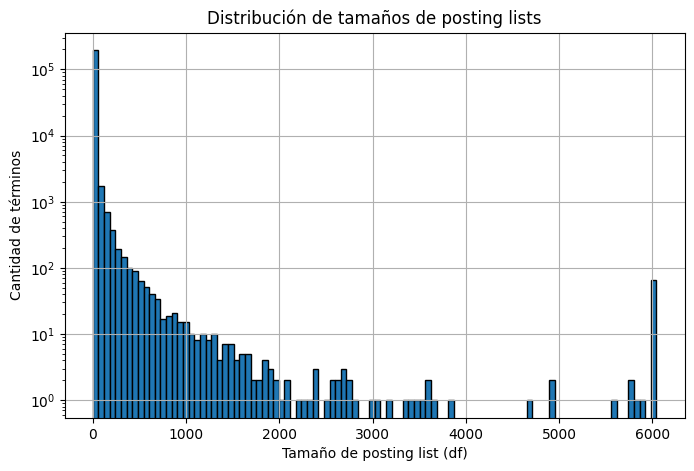

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(resultados[1]["posting_sizes"], bins=100, edgecolor="black", log=True)
plt.xlabel("Tamaño de posting list (df)")
plt.ylabel("Cantidad de términos")
plt.title(f"Distribución de tamaños de posting lists")
plt.grid(True)
plt.show()

## Cálculo del overhead del índice respecto de la colección

In [ ]:
for r in resultados:
    overhead = (r["size_postings"] + r["size_vocab"]) / size_corpus
    print(f"n={r['n']}: Overhead del índice = {overhead*100:.2f}%")

Tamaño total de la colección: 146.01 MB
n=604: Overhead del índice = 13.58%
n=1208: Overhead del índice = 13.58%
n=3021: Overhead del índice = 13.58%
